#  **03: MODEL - LSTM**
### José Eduardo Viveros Escamilla | A01710605

Importamos todas las librerías necesarias para el entrenamiento del modelo, configuración de visualizaciones y establece seeds para reproducibilidad.

In [1]:
# Imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input

# Métricas
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Configuración
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Seeds para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

Cargamos los arrays del ETL y el tokenizer seriliazado 

In [2]:
# Rutas
PROCESSED_DIR = 'data/processed_data/v1_base/'
MODEL_DIR = 'models/'

# Crear directorio de modelos si no existe
import os
os.makedirs(MODEL_DIR, exist_ok=True)

# Cargar datos
print("Cargando datos procesados...")
X_train = np.load(PROCESSED_DIR + 'X_train.npy')
X_val = np.load(PROCESSED_DIR + 'X_val.npy')
X_test = np.load(PROCESSED_DIR + 'X_test.npy')

y_train = np.load(PROCESSED_DIR + 'y_train.npy')
y_val = np.load(PROCESSED_DIR + 'y_val.npy')
y_test = np.load(PROCESSED_DIR + 'y_test.npy')

# Cargar tokenizer
with open(PROCESSED_DIR + 'tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

print(f"Datos cargados correctamente")
print(f"Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Vocabulario: {len(tokenizer.word_index)} palabras")

Cargando datos procesados...
Datos cargados correctamente
Shapes:
X_train: (1280000, 50), y_train: (1280000,)
X_val: (160000, 50), y_val: (160000,)
X_test: (160000, 50), y_test: (160000,)
Vocabulario: 411614 palabras


In [3]:
# Hiperparámetros (deben coincidir con el ETL)
# Vocabulario y longitud máxima de secuencia que usaremos
MAX_WORDS = 20000
# Tamaño de la salida que queremos que tenga cada secuecnia
MAX_LEN = 50

# Hiperparámetros de entrenamiento
EMBEDDING_DIM = 150
LSTM_UNITS = 80     
DROPOUT_RATE = 0.2
BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 5e-4

print("Hiperparámetros del modelo:")
print(f"   MAX_WORDS: {MAX_WORDS}, MAX_LEN: {MAX_LEN}")
print(f"   EMBEDDING_DIM: {EMBEDDING_DIM}, LEARNING_RATE: {LEARNING_RATE}")
print(f"   BI_LSTM_UNITS: {LSTM_UNITS}, DROPOUT_RATE: {DROPOUT_RATE}")
print(f"   BATCH_SIZE: {BATCH_SIZE}, EPOCHS: {EPOCHS}")

Hiperparámetros del modelo:
   MAX_WORDS: 20000, MAX_LEN: 50
   EMBEDDING_DIM: 150, LEARNING_RATE: 0.0005
   BI_LSTM_UNITS: 80, DROPOUT_RATE: 0.2
   BATCH_SIZE: 256, EPOCHS: 10


Construimos la arquitectura del modelo LSTM bidireccional
1. Primero con una capa de Embeddings que tiene como maximo 50 como numero de tokens
2. Despues agregamos una capa de LSTM bidereccional, para que recora de ida y de regreso nuestro texto, 128 neuronas
3. Agregamos un dropout que funcione como regulador 
4. Despues agregamos una capa tracional de LSTM, con 64 neuronas
5. El dropout de 0.2 que nos indicara la salida 
6. Y por ultimo una capa de salida densa con Sigmoid, pues nuestro problema es de clasifiacion de dos clases, entonces no ocupamos más

In [4]:
from tensorflow.keras.layers import GlobalMaxPooling1D

model = Sequential([
    Embedding(input_dim=MAX_WORDS+1, output_dim=EMBEDDING_DIM),
    
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
    GlobalMaxPooling1D(),

    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4, weight_decay=1e-4),
    metrics=['accuracy']
)

Configuramos callbacks para detener el entrenamiento si no mejora (EarlyStopping) y guardar automáticamente el mejor modelo (ModelCheckpoint). Esto nos ayuda demasiado a evitar overfitting y asegura que guardas la mejor versión.

In [5]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    MODEL_DIR + 'deeptweet_v1_base.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint]

print("Callbacks configurados:")
print("   - EarlyStopping: detiene si val_loss no mejora en 2 épocas")
print("   - ModelCheckpoint: guarda el mejor modelo según val_accuracy")

Callbacks configurados:
   - EarlyStopping: detiene si val_loss no mejora en 2 épocas
   - ModelCheckpoint: guarda el mejor modelo según val_accuracy


In [6]:
# Entrenar modelo
print("\nIniciando entrenamiento...")
print("=" * 60)

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n Entrenamiento completado")
print(f" Modelo guardado en: {MODEL_DIR}deeptweet_v1_base.h5")


Iniciando entrenamiento...
Epoch 1/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7577 - loss: 0.4937
Epoch 1: val_loss improved from None to 0.44201, saving model to models/deeptweet_v1_base.h5


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 595s 119ms/step - accuracy: 0.7793 - loss: 0.4637 - val_accuracy: 0.7927 - val_loss: 0.4420
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7965 - loss: 0.4345
Epoch 2: val_loss improved from 0.44201 to 0.43723, saving model to models/deeptweet_v1_base.h5


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 587s 117ms/step - accuracy: 0.7991 - loss: 0.4301 - val_accuracy: 0.7966 - val_loss: 0.4372
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8067 - loss: 0.4165
Epoch 3: val_loss did not improve from 0.43723
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 561s 112ms/step - accuracy: 0.8090 - loss: 0.4124 - val_accuracy: 0.7957 - val_loss: 0.4413
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8169 - loss: 0.3985
Epoch 4: val_loss did not improve from 0.43723
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 593s 118ms/step - accuracy: 0.8197 - loss: 0.3936 - val_accuracy: 0.7922 - val_loss: 0.4539
Epoch 5/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8280 - loss: 0.3787
Epoch 5: val_loss did not improve from 0.43723
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 584s 117ms/step - accuracy: 0.8309 - loss: 0.3732 - val_accuracy: 0.7882 - val_loss: 0.4769
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

 Entrenamient

Visualizamos la evolución de la pérdida (loss) y accuracy durante el entrenamiento para ambos conjuntos (train y validation)

Evaluamos el rendimiento del modelo final sobre el conjunto de prueba, que contiene ejemplos nunca vistos durante el entrenamiento. Esto permite medir la capacidad real de generalización del modelo.

In [7]:
print("Evaluando en el set de prueba...")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss:     {test_loss:.4f}")

Evaluando en el set de prueba...
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - accuracy: 0.7953 - loss: 0.4375

Test Accuracy: 0.7953
Test Loss:     0.4375


In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Accuracy de Test: {test_acc:.4f}")
print(f"Loss de Test:     {test_loss:.4f}")

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 56s 11ms/step - accuracy: 0.7953 - loss: 0.4375
Accuracy de Test: 0.7953
Loss de Test:     0.4375


In [9]:
# Obtener probabilidades
y_pred_prob = model.predict(X_test, batch_size=256)

# Convertir a etiquetas binarias
y_pred = (y_pred_prob > 0.5).astype(int)

625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step


La matriz de confusión permite visualizar cuántos ejemplos fueron clasificados correctamente para cada clase y cuántos fueron confundidos.

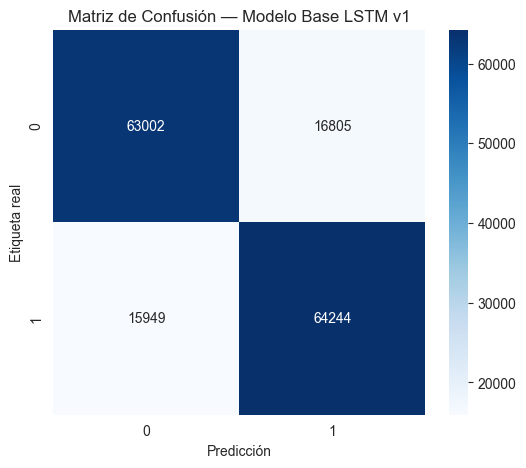

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión — Modelo Base LSTM v1")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.show()

In [11]:
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.79      0.79     79807
    Positive       0.79      0.80      0.80     80193

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000



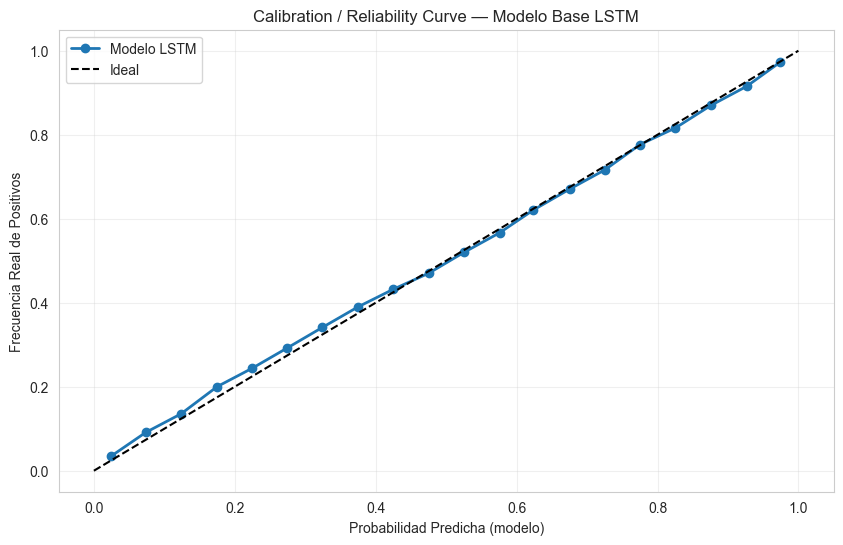

In [12]:
from sklearn.calibration import calibration_curve
# Calcular curva de calibración
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=20)

plt.figure(figsize=(10,6))

# Curva del modelo
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Modelo LSTM')

# Línea ideal
plt.plot([0,1], [0,1], 'k--', label='Ideal')

plt.title("Calibration / Reliability Curve — Modelo Base LSTM")
plt.xlabel("Probabilidad Predicha (modelo)")
plt.ylabel("Frecuencia Real de Positivos")
plt.legend()
plt.grid(alpha=0.3)
plt.show()